# CharacterTrajectories Forecasting Visualizations

## Overview

This notebook contains the code for visualizing the trajectories forecasted by the sequential models based on 70% sequence data from the CharacterTrajectories dataset.

In [1]:
import sys
import os

# Get the current working directory
_here = os.path.abspath(os.path.dirname(''))

# Append the parent directory to sys.path
sys.path.append(os.path.abspath(os.path.join(_here, '../../')))

import torch
import torch.nn as nn
import torchcde
import numpy as np
from src.models.TransformerSeq import Transformer
from src.models.NeuralCDETransformer import NeuralCDETransformer
from src.models.NeuralCDEODE import NeuralCDEODE
from src.data.cde_transforms import preprocess_for_transformer, fill_forward

# Set up matplotlib
import matplotlib.pyplot as plt

In [2]:
datapath = '../../data/processed/CharacterTrajectories/regression/30'

X = torch.load(f'{datapath}/X_test.pt')
y = torch.load(f'{datapath}/y_test.pt')

In [3]:
def strip_time(x):
    # Strip time channel
    x = x[:, :, 1:]

    # Get mask of y (where all values are zero)
    mask = x == 0
    mask = ~mask

    return x, mask

def plot_trajectory(x_batch, pred_y, id):
    pred_y = pred_y.detach().numpy()
    x_batch = x_batch.detach().numpy()

    pred_y = pred_y[id]
    x_batch = x_batch[id]

    x_batch = x_batch[:, 1:]

    pred_y = np.concatenate([x_batch, pred_y], axis=0)

    # Plot predicted trajectory and ground truth trajectory
    pred_vx, pred_vy, pred_f = [pred_y[: , i] for i in range(3)]

    # Integrate velocities to get positions
    pred_x, pred_y = np.cumsum(pred_vx), np.cumsum(pred_vy)

    # Remove last element and insert 0 to the beginning
    pred_x, pred_y = np.insert(pred_x[:-1], 0, 0), np.insert(pred_y[:-1], 0, 0)

    # Handle NaN values by only considering non-NaN values for normalization
    min_value, max_value = np.nanmin(pred_f), np.nanmax(pred_f)
    pred_f_normal = (pred_f - min_value) / (max_value - min_value)

    # Determine index for splitting the line into two segments
    split_index = int(0.7 * len(pred_x))

    # Plot
    plt.figure(figsize=(6, 6))
    plt.plot(pred_x[:split_index], pred_y[:split_index], label='Initial (blue)', color='blue')
    plt.plot(pred_x[split_index:], pred_y[split_index:], label='Forecast (red)', color='red')
    plt.scatter(pred_x, pred_y, c=pred_f_normal, cmap='viridis', label='Predicted force')
    plt.colorbar()
    plt.legend()
    plt.title('Forecasting of CharacterTrajectories')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

## Ground Truth

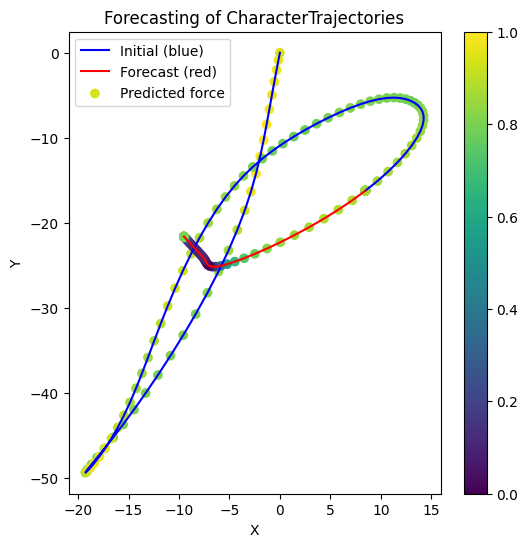

In [4]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1
}

X_test, test_mask = preprocess_for_transformer(X)
X_test = X_test.float()
y_test = y.float()

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, test_mask, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

batch_x, _, batch_y = next(iter(test_dataloader))

# Get mask of batch_y (where all values are zero)
batch_y, mask = strip_time(batch_y)

plot_trajectory(batch_x, batch_y, 25)

## Transformer Encoder-Decoder Model

/cim/faverog/ECSE552-project/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


The model has 838,307 trainable parameters


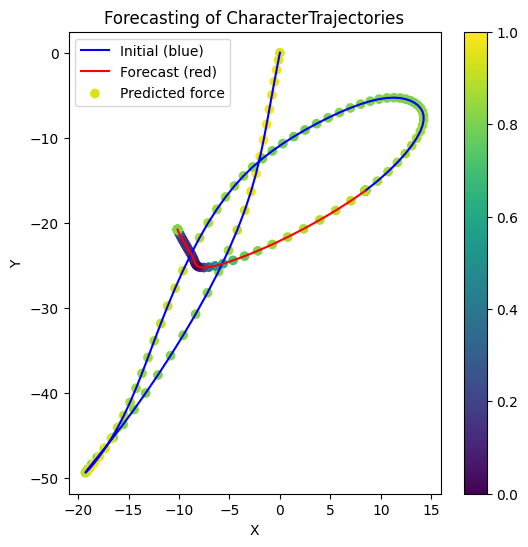

In [5]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1
}

X_test, test_mask = preprocess_for_transformer(X)
X_test = X_test.float()
y_test = y.float()

# Set up test dataloader
test_dataset = torch.utils.data.TensorDataset(X_test, test_mask, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = Transformer(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], HP['n_heads'], HP['n_layers'], HP['dropout'])

# Load model
model.load_state_dict(torch.load('logs/transformer_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, batch_mask, batch_y = next(iter(test_dataloader))
pred_y = model(batch_x, batch_y, batch_mask)
pred_y = pred_y.squeeze(-1)
pred_y = pred_y.permute(1, 0, 2)

# Get mask of batch_y (where all values are zero)
batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)

## Neural CDE-Transformer Model

The model has 433,187 trainable parameters


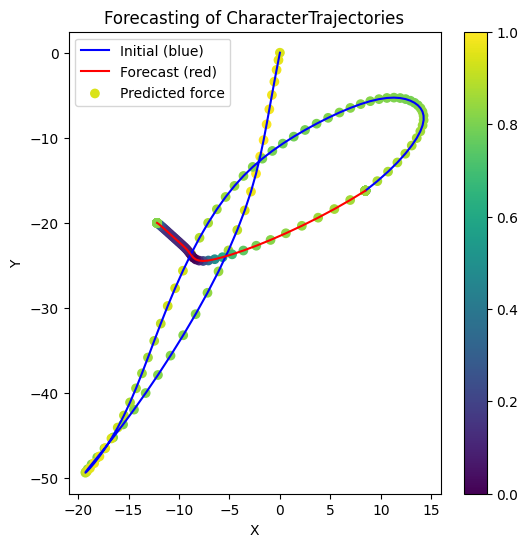

In [6]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'n_heads': 4,
    'n_layers': 3,
    'dropout': 0.1,
     'method': 'rk4',
    'step_size': 1
}

# Preprocess data
X_test = fill_forward(X)
y_test = y.float()

# Set up test dataloader
test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_test)
test_dataset = torch.utils.data.TensorDataset(X, test_coeffs, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralCDETransformer(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], HP['n_heads'], HP['n_layers'], HP['dropout'])

# Load model
model.load_state_dict(torch.load('logs/ncdetransformer_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, coeffs, batch_y = next(iter(test_dataloader))
pred_y = model(coeffs, batch_y)
pred_y = pred_y.squeeze(-1)
pred_y = pred_y.permute(1, 0, 2)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)

## Neural CDE-ODE

The model has 11,875 trainable parameters


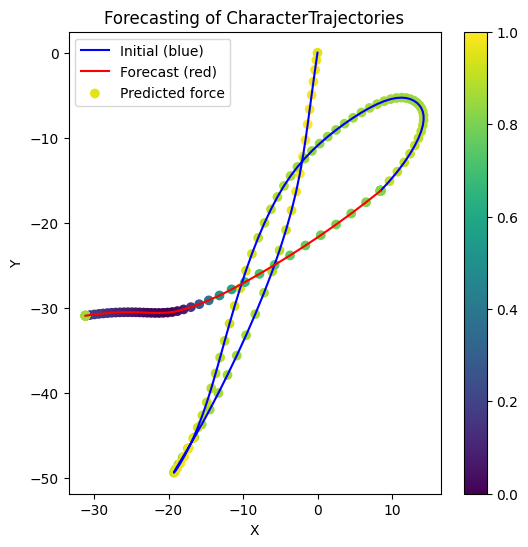

In [7]:
# Define hyperparameters
HP = {
    'log_dir': '/logs',
    'data_path': '../../data/processed/CharacterTrajectories/regression/30',
    'epochs': 150,
    'lr': 1e-3,
    'batch_size': 32,
    'input_channels': 4,
    'hidden_channels': 32,
    'output_channels': 3,
    'hidden_layers': 3,
    'method': 'rk4',
    'step_size': 1
}

# Preprocess data
X_test = fill_forward(X)
y_test = y.float()

# Set up test dataloader
test_coeffs = torchcde.hermite_cubic_coefficients_with_backward_differences(X_test)
test_dataset = torch.utils.data.TensorDataset(X, test_coeffs, y_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=HP['batch_size'])

# Define model
model = NeuralCDEODE(HP['input_channels'], HP['hidden_channels'], HP['output_channels'], missing_data=0.3)

# Load model
model.load_state_dict(torch.load('logs/ncdeode_model.pth'))

# Print the number of parameters
print(f'The model has {sum(p.numel() for p in model.parameters() if p.requires_grad):,} trainable parameters')

# Set model to evaluation mode
model.eval()

batch_x, coeffs, batch_y = next(iter(test_dataloader))
pred_y = model(coeffs)
pred_y = pred_y.squeeze(-1)

batch_y, mask = strip_time(batch_y)

# Apply mask to pred_y
pred_y = pred_y * mask

plot_trajectory(batch_x, pred_y, 25)